In [0]:
import imageio
import cv2
import numpy as np
import os
import pickle
import re
import PIL
from PIL import Image

## Challenge Categories

In [0]:
CATEGORIES = [
    "boxing",
    "handclapping",
    "handwaving",
    "jogging",
    "running",
    "walking"
]

IMG_W = 60
IMG_H = 80
CHANNELS = 1
INPUT_SHAPE = (IMG_W, IMG_H, CHANNELS)
NCLASSES = 6
MAX_TRAIN_DEV_FRAMES_PER_VIDEO = 0 # NO MAX NEEDED = EXTRACT ALL FRAMES  
MAX_TEST_FRAMES_PER_VIDEO = 40 # 40 frames per each video to perform average prediction over each video

EPOCHS = 5
BATCH_SIZE = 64

### Spliting The Dataset

In [0]:
# Dataset are divided according to the instruction at:
# http://www.nada.kth.se/cvap/actions/00sequences.txt
TRAIN_PEOPLE_ID = [11, 12, 13, 14, 15, 16, 17, 18]
DEV_PEOPLE_ID = [19, 20, 21, 23, 24, 25, 1, 4]
TEST_PEOPLE_ID = [22, 2, 3, 5, 6, 7, 8, 9, 10]

## Loading The Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
print("Loading dataset ..")
train_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/train.p", "rb"))
dev_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/dev.p", "rb"))
test_videos = pickle.load(open("/content/drive/My Drive/DATASETS/KTH/Dataset pickles/test.p", "rb"))

Loading dataset ..


##Preparing The Dataset

In [0]:
def read_ds(ds="train", max_frames_per_video=0, separate_each_video=False):
  if(ds == "dev"):
    videos = dev_videos
  elif (ds == "test"):
    videos = test_videos
  else:
    videos = train_videos
      
  X = []
  y = []
  i=0
  X_per_video = []
  y_per_video = []
  print("total videos : %s" % len(videos))

  for video in videos: 

    if(max_frames_per_video == 0):

        for frame in video["frames"]:
            X.append(frame.reshape(INPUT_SHAPE))
            y.append(CATEGORIES.index(video["category"]))
  
        if(separate_each_video):
            X_per_video.append(np.array(X, dtype=np.float32))
            y_per_video.append(np.array(y, dtype=np.uint8))
            X = []
            y = []  
        
    elif(max_frames_per_video == 1):

        index = np.random.choice(len(video["frames"]))
        frame_data = video["frames"][index]
  
        X.append(frame_data.reshape(INPUT_SHAPE))
        y.append(CATEGORIES.index(video["category"]))

    else:

        skip = (len(video["frames"]) // max_frames_per_video)

        for i in range(0, len(video["frames"]), skip):
          X.append(np.array(video["frames"][i].reshape(INPUT_SHAPE), dtype=np.float32))
        
        y.append(np.array(CATEGORIES.index(video["category"]), dtype=np.uint8))
        
        
        X = X[:max_frames_per_video]
        
        X_per_video.append(np.array(X, dtype=np.float32))
        y_per_video.append(np.array(y, dtype=np.uint8))

        X = []
        y = []  
      

  X = np.array(X, dtype=np.float32)
  y = np.array(y, dtype=np.uint8)


  if (max_frames_per_video == 0):
    if(separate_each_video):
      for x in X_per_video:
        mean = np.mean(x)
        x -= float(mean)
        return np.array(X_per_video), np.array(y_per_video)
    
    mean = np.mean(X)
    X -= float(mean)
    
    return X, y

  elif (max_frames_per_video == 1):
    mean = np.mean(X)
    X -= float(mean)

    return X, y
  

  else: # (max_frames_per_video > 1):
    for x in X_per_video:
      mean = np.mean(x)
      x -= float(mean)
      
    return np.array(X_per_video), np.array(y_per_video)

In [0]:
X_train, y_train = read_ds(ds="train", max_frames_per_video=MAX_TRAIN_DEV_FRAMES_PER_VIDEO)
X_dev, y_dev = read_ds(ds="dev", max_frames_per_video=MAX_TRAIN_DEV_FRAMES_PER_VIDEO)
X_test, y_test = read_ds(ds="test", max_frames_per_video=MAX_TRAIN_DEV_FRAMES_PER_VIDEO)
X_test_average_prediction, y_test_average_prediction = read_ds(ds="test", max_frames_per_video=MAX_TEST_FRAMES_PER_VIDEO)

total videos : 191
total videos : 192
total videos : 216
total videos : 216


In [0]:
y_train

array([0, 0, 0, ..., 5, 5, 5], dtype=uint8)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.layers import Input, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, add
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)
y_test = to_categorical(y_test)

##Preparing The Model (2D CNN - VGG16 Style)

In [0]:
# CNN model (VGG like)
model = Sequential()

## Stage 2
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMG_W, IMG_H, CHANNELS)))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Stage 3
model.add(Conv2D(64,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Stage 4
model.add(Conv2D(128,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu',padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),padding='valid'))

## Output
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NCLASSES,activation='softmax'))

In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 58, 78, 32)        320       
_________________________________________________________________
batch_normalization_36 (Batc (None, 58, 78, 32)        128       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 56, 76, 32)        9248      
_________________________________________________________________
batch_normalization_37 (Batc (None, 56, 76, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 26, 36, 64)        18496     
_________________________________________________________________
batch_normalization_38 (Batc (None, 26, 36, 64)       

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

##Training The Model

In [0]:
trained_model = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data=(X_dev, y_dev) , shuffle=True)

Train on 74672 samples, validate on 72821 samples
Epoch 1/5
74672/74672 [==============================] - 37s 501us/step - loss: 0.7270 - acc: 0.6939 - val_loss: 1.2718 - val_acc: 0.5692
Epoch 2/5
74672/74672 [==============================] - 35s 467us/step - loss: 0.3548 - acc: 0.8449 - val_loss: 1.3664 - val_acc: 0.5938
Epoch 3/5
74672/74672 [==============================] - 35s 467us/step - loss: 0.2375 - acc: 0.9016 - val_loss: 1.9312 - val_acc: 0.5406
Epoch 4/5
74672/74672 [==============================] - 35s 467us/step - loss: 0.1658 - acc: 0.9319 - val_loss: 1.4545 - val_acc: 0.5731
Epoch 5/5
74672/74672 [==============================] - 35s 469us/step - loss: 0.1319 - acc: 0.9490 - val_loss: 1.7100 - val_acc: 0.6000


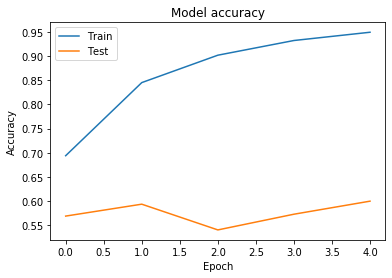

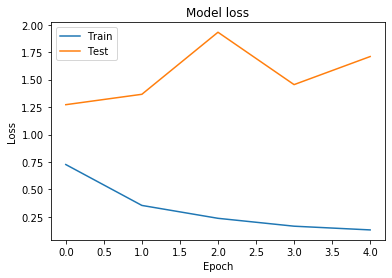

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##Evaluating The Model (No Average Prediction Computed)

In [0]:
model.evaluate(X_test, y_test)

79266/79266 [==============================] - 13s 160us/step


[1.87650108276573, 0.564037544470517]

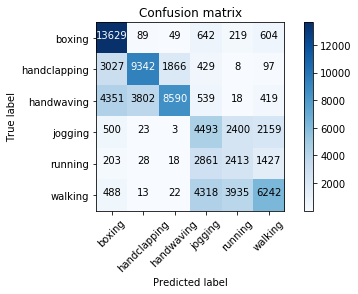

In [0]:
# Confusion matrix 
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = CATEGORIES) 

##Evaluating The Model Using Average Prediction

In [0]:
def cat(tupleOfArrays, axis=0):
    assert isinstance(tupleOfArrays, tuple), 'first var should be tuple of arrays'

    firstFlag = True
    res = np.array([])
    
    for i in range(len(tupleOfArrays)):
        x = tupleOfArrays[i]
        if len(x) > 0: 
            if isinstance(x, list):  
                x = np.array(x)
            if x.ndim == 1: 
                x = x.reshape((1, -1))
            if firstFlag: 
                res = x
                firstFlag = False
            else: 
                if axis == 0:
                    assert res.shape[1] == x.shape[1], "Error concating vertically element index " + str(i) + \
                                                       " with prior elements: given mat shapes are " + \
                                                       str(res.shape) + " & " + str(x.shape)
                else:  # axis == 1:
                    assert res.shape[0] == x.shape[0], "Error concating horizontally element index " + str(i) + \
                                                       " with prior elements: given mat shapes are " + \
                                                       str(res.shape) + " & " + str(x.shape)

                res = np.concatenate((res, x), axis=axis)
    return res

In [0]:
preds = np.array([])
pred_y = []
i = 0
for video_frames in X_test_average_prediction:
  y_per_vid = np.array([])


  if(len(video_frames.shape) == 3):
    y_per_vid = cat((y_per_vid, y_test_average_prediction[i]), axis=0)

    p = model.predict(np.expand_dims(video_frames, axis=0))
    results = np.array(p).mean(axis=0)
    index = np.argmax(results)
    label = CATEGORIES[index]
    pred_y.append(index)

    preds = cat((preds, p))

  else:

    for video_frame in video_frames:
      y_per_vid = cat((y_per_vid, y_test_average_prediction[i]), axis=0)

    p = model.predict(video_frames)

    results = np.array(p).mean(axis=0)
    index = np.argmax(results)
    label = CATEGORIES[index]
    pred_y.append(index)

    preds = cat((preds, p))

    i+=1

pred_y = np.array(pred_y, dtype=np.str)

In [0]:
preds.shape, pred_y.shape

((8640, 6), (216,))

In [0]:
y_test_per_video_classes = []
_, y_test_per_video = read_ds(ds="test", max_frames_per_video=1)
y_test_per_video = to_categorical(y_test_per_video)

for y in y_test_per_video:
  index = np.argmax(y)
  label = CATEGORIES[index]
  y_test_per_video_classes.append(index)
y_test_per_video_classes = np.array(y_test_per_video_classes, dtype=np.str)

total videos : 216


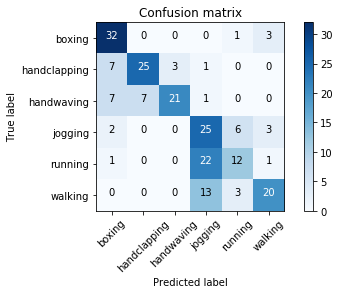

In [0]:
confusion_mtx = confusion_matrix(y_test_per_video_classes, pred_y) 
plot_confusion_matrix(confusion_mtx, classes = CATEGORIES) 

In [0]:
y_test_per_video_classes.shape

(216,)

In [0]:
i=0
acc=0
for y in pred_y:
  if(y == y_test_per_video_classes[i]):
    acc+=1
  i+=1

accuracy = acc / len(pred_y)
print("Average Prediction Per Video Accuracy : %s" % accuracy)

Average Prediction Per Video Accuracy : 0.625


##Saving The Model 

In [0]:
model.save_weights('SingleFrameModel_KTH.h5')

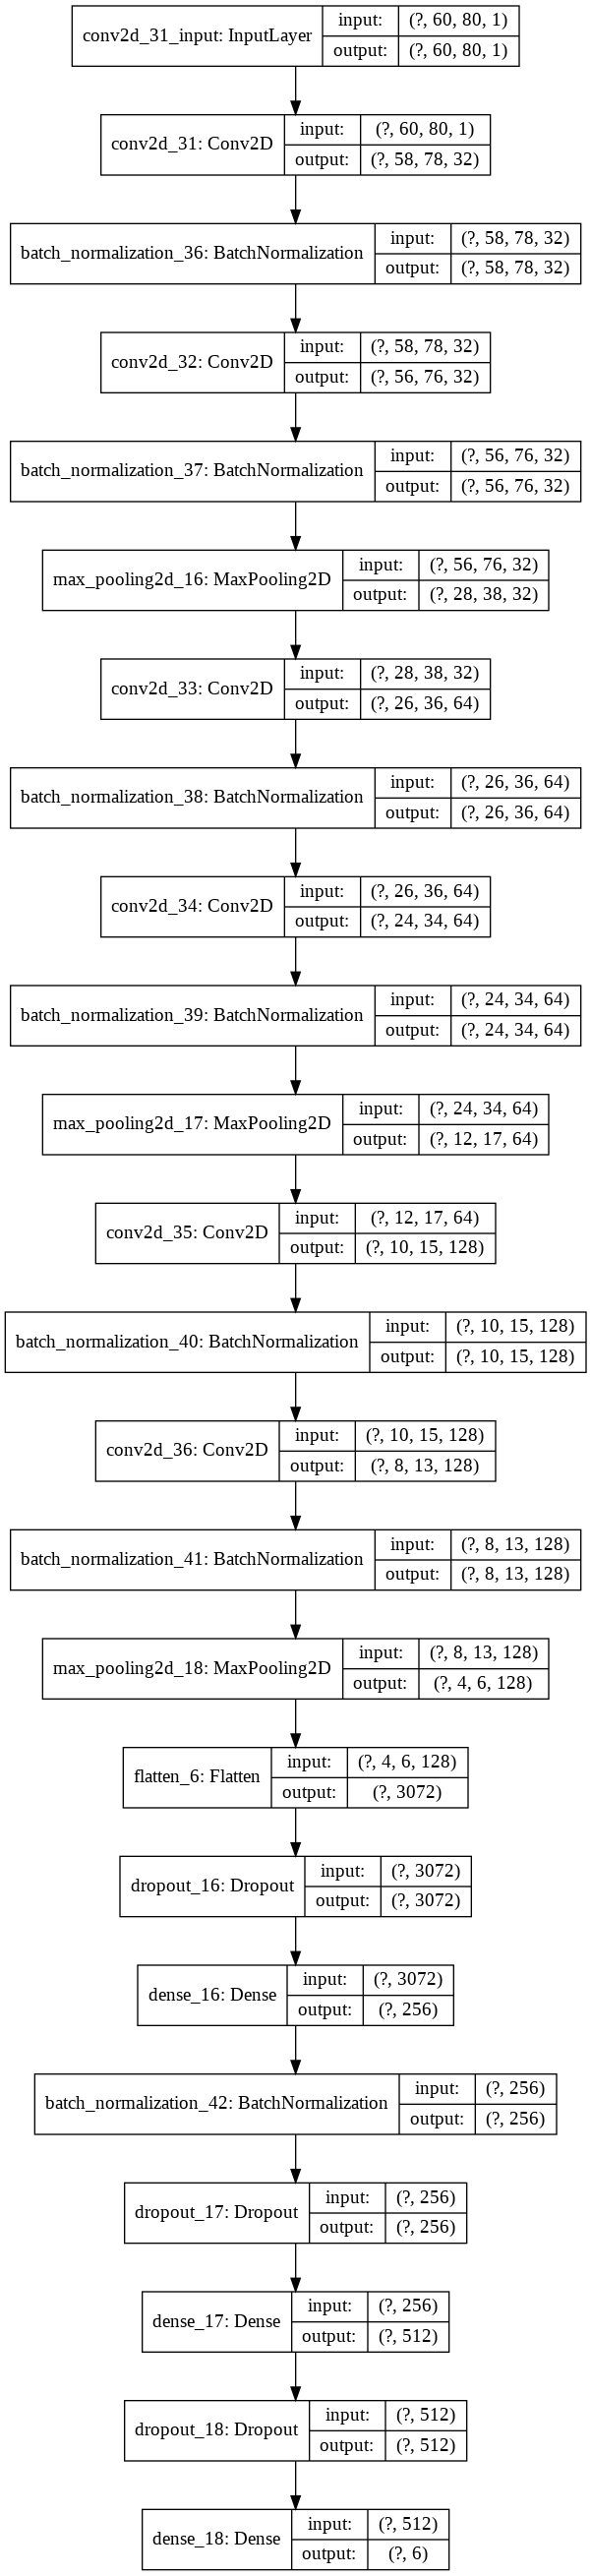

In [0]:
plot_model(model, show_shapes=True, to_file='SingleFrameModel_KTH.png')